## Name: Paul Hickey
## ID: 22267964

# Tasks
- Plot the sum of squared distances from the data points (in loans_train_prepared.csv) to the centers of the k-means clusters for various values of k. 
- Use the Elbow method to pick the best value of k.
- Attempt also another method for determining the best value of k.
- Use the best value(s) of k to cluster the loans_train_prepared dataset with k-means. Aim at producing meaningful clustering.
- Use at least two different methods for visualising the clustering. 
- Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).
- Use another clustering algorithm (from the ones available in scikit-learn) for the loans_train_prepared dataset and an appropriate manifold-learning technique to visualise it.
- Discuss the differences between the k-Means clustering and the clustering found by the second algorithm you have tried in words (max 250 words in a markdown cell) and by visualising the clusterings with an appropriate manifold-learning technique.

# 1. Intial setup

## Import modules

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing

## Import data

In [203]:
df = pd.read_csv("./loans_train_prepared-1.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


In [204]:
df.head()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0    0.000000         1.084523    1.058140              0.75               1   
1    0.333333         0.925883    1.047319              0.75               1   
2    0.000000         0.683858    0.635920              0.75               1   
3    0.000000         0.608992    1.002824              0.75               1   
4    0.000000         1.101869    1.115650              0.75               1   

   Gender_Male  Gender_nan  Married_Yes  Married_nan  Self_Employed_Yes  \
0            1           0            0            0                  0   
1            1           0            1            0                  0   
2            1           0            1            0                  1   
3            1           0            1            0                  0   
4            1           0            0            0                  0   

   Self_Employed_nan  Education_Not Graduate  Property_Area_Semiurban  \
0                  0                       0                        0   
1                  0                       0                        0   
2                  0                       0                        0   
3                  0                       1                        0   
4                  0                       0                        0   

   Property_Area_Urban  Loan_Status_Y  TotalIncome  
0                    1              1     0.841086  
1                    0              0     0.871711  
2                    1              1     0.385189  
3                    1              1     0.717012  
4                    1              1     0.860305

In [205]:
df.describe()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
count  614.000000       614.000000  614.000000        614.000000   
mean     0.248100         0.916588    1.076222          0.713355   
std      0.336541         0.412366    0.338744          0.134226   
min      0.000000         0.004634    0.005026          0.025000   
25%      0.000000         0.662440    0.883668          0.750000   
50%      0.000000         0.815365    1.047319          0.750000   
75%      0.333333         1.078246    1.229571          0.750000   
max      1.000000         3.357480    2.461145          1.000000   

       Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
count      614.000000   614.000000  614.000000   614.000000   614.000000   
mean         0.855049     0.796417    0.021173     0.648208     0.004886   
std          0.352339     0.402991    0.144077     0.477919     0.069786   
min          0.000000     0.000000    0.000000     0.000000     0.000000   
25%          1.000000     1.000000    0.000000     0.000000     0.000000   
50%          1.000000     1.000000    0.000000     1.000000     0.000000   
75%          1.000000     1.000000    0.000000     1.000000     0.000000   
max          1.000000     1.000000    1.000000     1.000000     1.000000   

       Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
count         614.000000         614.000000              614.000000   
mean            0.133550           0.052117                0.218241   
std             0.340446           0.222445                0.413389   
min             0.000000           0.000000                0.000000   
25%             0.000000           0.000000                0.000000   
50%             0.000000           0.000000                0.000000   
75%             0.000000           0.000000                0.000000   
max             1.000000           1.000000                1.000000   

       Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
count               614.000000           614.000000     614.000000   
mean                  0.379479             0.328990       0.687296   
std                   0.485653             0.470229       0.463973   
min                   0.000000             0.000000       0.000000   
25%                   0.000000             0.000000       0.000000   
50%                   0.000000             0.000000       1.000000   
75%                   1.000000             1.000000       1.000000   
max                   1.000000             1.000000       1.000000   

       TotalIncome  
count   614.000000  
mean      0.862686  
std       0.428068  
min       0.005599  
25%       0.597383  
50%       0.783902  
75%       1.035796  
max       3.207353

We can see that the 3 features, *ApplicantIncome*, *LoanAmount* and *TotalIncome*, have a slightly larger range than the others. These features could potentially be standardised to bring them within a similar range but, as they are, their magnitude is unlikely to be problematic.

## Setup helpers

In [206]:
colors = np.array(['#8a00d4', '#d527b7', '#f782c2', '#f9c46b', '#e3e3e3', '#e74645', '#fb7756', '#1ac0c6', '#309975', '#58b368', '#dad873', '#efeeb4'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    
    plt.figure(figsize=(12, 8))
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1],
                        marker='.', 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='#454d66', marker='o')
        
    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

# 2. K-means clustering
- Plot the sum of squared distances from the data points (in loans_train_prepared.csv) to the centers of the k-means clusters for various values of k
- Use the Elbow method to pick the best value of k.
- Attempt also another method for determining the best value of k.
- Use the best value(s) of k to cluster the loans_train_prepared dataset with k-means. Aim at producing meaningful clustering.
- Use at least two different methods for visualising the clustering.
- Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

## Identify optimal number of clusters
In order to make meaningful use of clustering we first need to identify the ideal number of clusters for our dataset. There are a number of ways of accomplishing this. 

### Elbow method
To use the Elbow method, we run the K-means algorithm a number of times and then compute the sum of square distances from each of the data points to the centre of their respective cluster. 

The sum of squared distances is 0 when each data point is treated as a cluster in its own right. Bearing that in mind, we want the sum of squared distances value to be as low as possible whilst also minimising **k** (the number of clusters) where possible. When we plot these sum of square distances, the *Elbow* refers to the point of maximum curvature in the plot, beyond which there are diminishing returns for increasing the value of **k**.

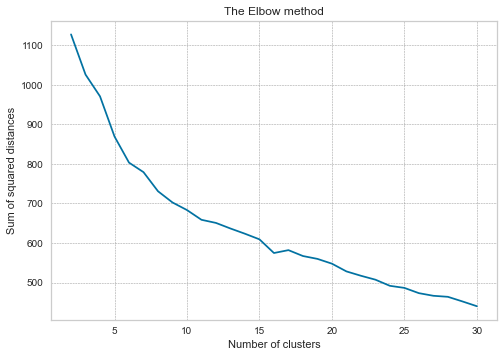

In [207]:
# Set max value of k
k_range = 30

ss_distance = []
k_list = list(range(2, k_range+1))

for k in k_list:
  kmeans = cluster.KMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=300, tol=1e-3, random_state=1)
  kmeans.fit(data)
  ss_distance.append(kmeans.inertia_)

plt.plot(k_list, ss_distance)
plt.title('The Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.grid(color = '#999', linestyle = '--', linewidth = 0.5)
plt.show()

From the plot above, we can see a few potential candidates for the *Elbow* point - 6, 9, 11 and 16 but none of them show a significant increase in curvature so they may not provide a good basis on which to assign clusters.

We can further explore the optimal number of clusters with some evaluation metrics and incorporate the results in our assessment.

### Model evaluation
#### Silhouette analysis
Silhouette analysis allows us to interpret the cohesion of clusters by assessing the distance between each cluster. The metric used to indicate cluster separation is the *Silhouette Coefficient*, which is in the range [-1, 1].

From the [documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):
> Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

-----------------------------------

2 Clusters


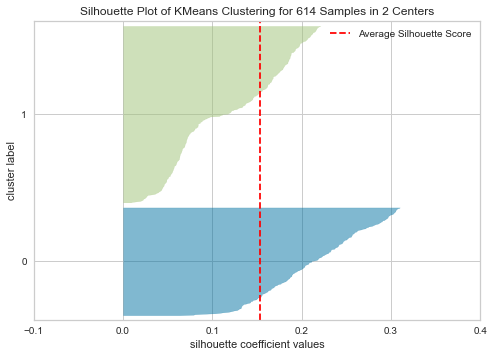

For n_clusters=2, The mean Silhouette Coefficient is 0.15345667241994654
For n_clusters=2, The Davies-Bouldin score is 2.238551012936858

-----------------------------------
-----------------------------------

3 Clusters


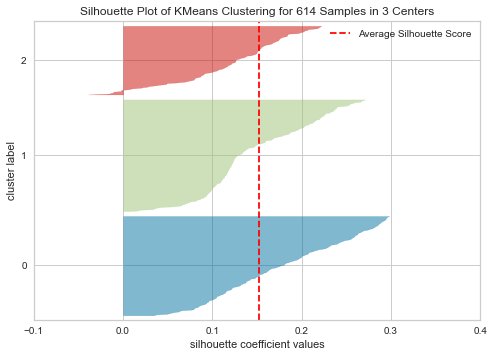

For n_clusters=3, The mean Silhouette Coefficient is 0.15185958210079736
For n_clusters=3, The Davies-Bouldin score is 2.187005514778214

-----------------------------------
-----------------------------------

4 Clusters


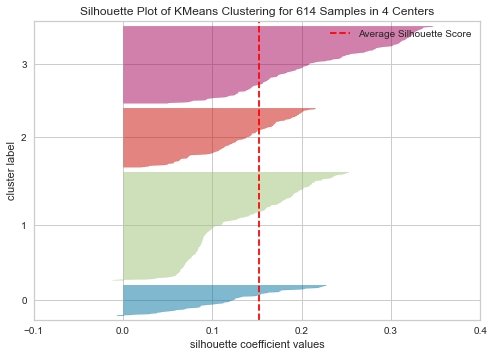

For n_clusters=4, The mean Silhouette Coefficient is 0.152364973426715
For n_clusters=4, The Davies-Bouldin score is 2.194026017931961

-----------------------------------
-----------------------------------

5 Clusters


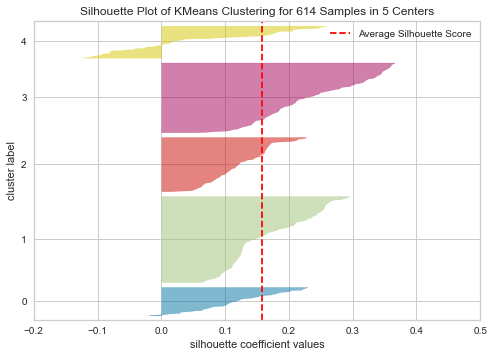

For n_clusters=5, The mean Silhouette Coefficient is 0.1572855107661596
For n_clusters=5, The Davies-Bouldin score is 1.981776835260323

-----------------------------------
-----------------------------------

6 Clusters


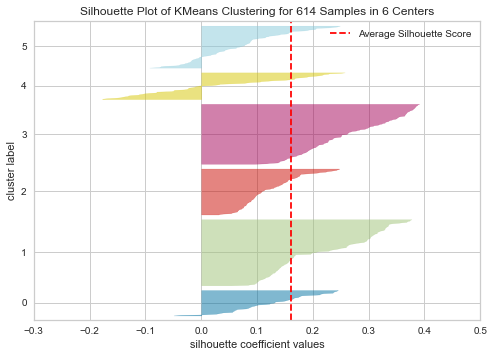

For n_clusters=6, The mean Silhouette Coefficient is 0.160562873400646
For n_clusters=6, The Davies-Bouldin score is 1.7831342483597437

-----------------------------------
-----------------------------------

7 Clusters


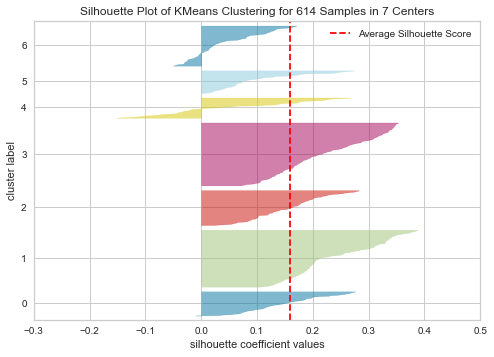

For n_clusters=7, The mean Silhouette Coefficient is 0.1590107541324332
For n_clusters=7, The Davies-Bouldin score is 1.8584493684839063

-----------------------------------
-----------------------------------

8 Clusters


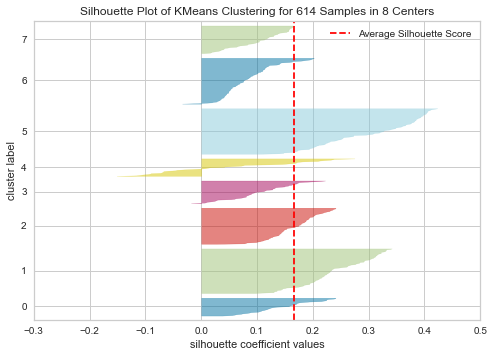

For n_clusters=8, The mean Silhouette Coefficient is 0.16673911496030855
For n_clusters=8, The Davies-Bouldin score is 1.7986875381453524

-----------------------------------
-----------------------------------

9 Clusters


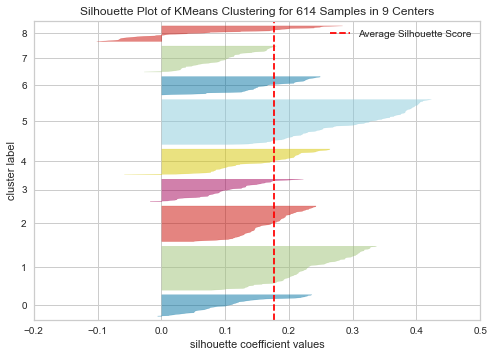

For n_clusters=9, The mean Silhouette Coefficient is 0.1771775404091867
For n_clusters=9, The Davies-Bouldin score is 1.8324294019614114

-----------------------------------
-----------------------------------

10 Clusters


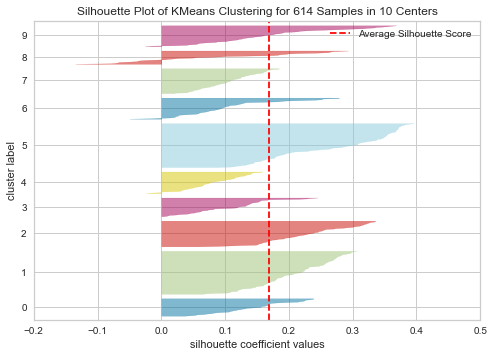

For n_clusters=10, The mean Silhouette Coefficient is 0.16908253724649833
For n_clusters=10, The Davies-Bouldin score is 1.7653145203948384

-----------------------------------
-----------------------------------

11 Clusters


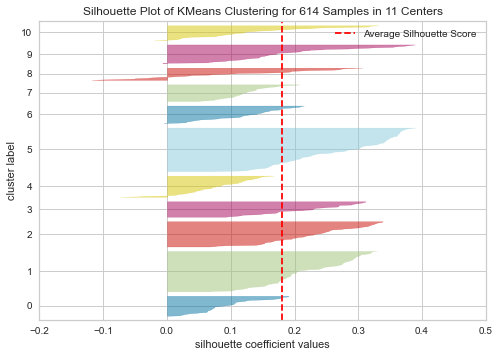

For n_clusters=11, The mean Silhouette Coefficient is 0.17987520885311223
For n_clusters=11, The Davies-Bouldin score is 1.7747390652636277

-----------------------------------
-----------------------------------

12 Clusters


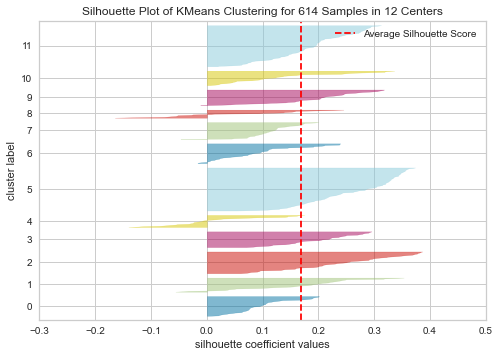

For n_clusters=12, The mean Silhouette Coefficient is 0.16843006588439527
For n_clusters=12, The Davies-Bouldin score is 1.8092055818882358

-----------------------------------
-----------------------------------

13 Clusters


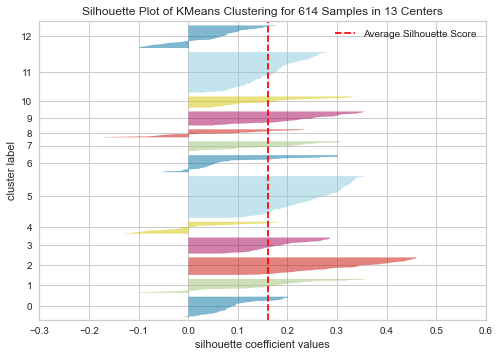

For n_clusters=13, The mean Silhouette Coefficient is 0.16110872309540022
For n_clusters=13, The Davies-Bouldin score is 1.7605569548671212

-----------------------------------
-----------------------------------

14 Clusters


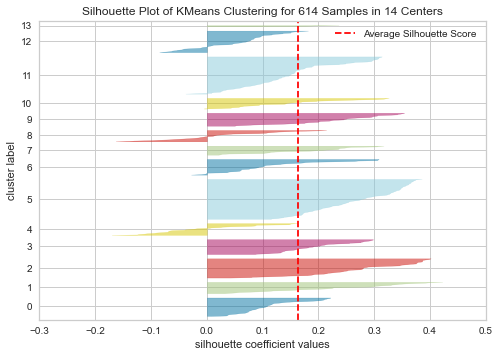

For n_clusters=14, The mean Silhouette Coefficient is 0.164017100831889
For n_clusters=14, The Davies-Bouldin score is 1.746417393567852

-----------------------------------
-----------------------------------

15 Clusters


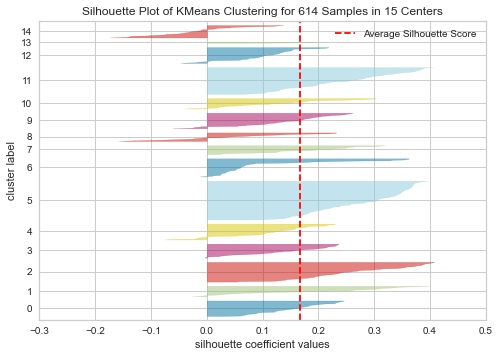

For n_clusters=15, The mean Silhouette Coefficient is 0.16752253327153824
For n_clusters=15, The Davies-Bouldin score is 1.7527224911003334

-----------------------------------
-----------------------------------

16 Clusters


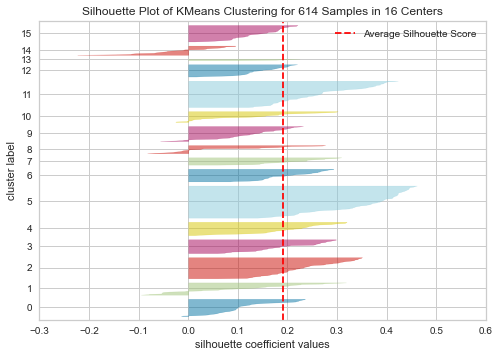

For n_clusters=16, The mean Silhouette Coefficient is 0.19032373006151262
For n_clusters=16, The Davies-Bouldin score is 1.7148341315276892

-----------------------------------
-----------------------------------

17 Clusters


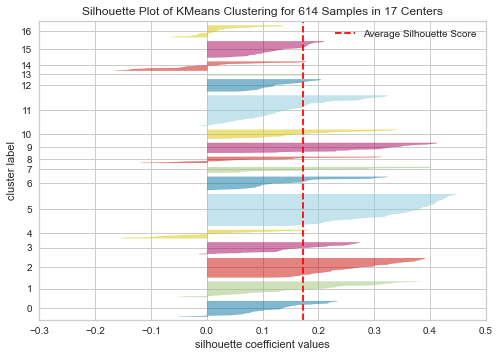

For n_clusters=17, The mean Silhouette Coefficient is 0.17172019294304533
For n_clusters=17, The Davies-Bouldin score is 1.7017291297055952

-----------------------------------
-----------------------------------

18 Clusters


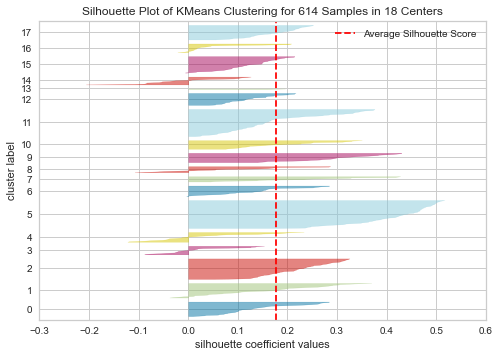

For n_clusters=18, The mean Silhouette Coefficient is 0.17682007561991375
For n_clusters=18, The Davies-Bouldin score is 1.6739707577270557

-----------------------------------
-----------------------------------

19 Clusters


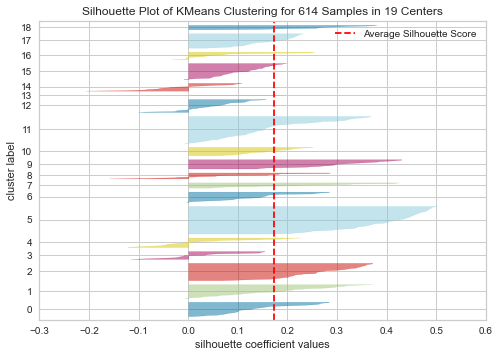

For n_clusters=19, The mean Silhouette Coefficient is 0.17323260845715768
For n_clusters=19, The Davies-Bouldin score is 1.6990148923166233

-----------------------------------
-----------------------------------

20 Clusters


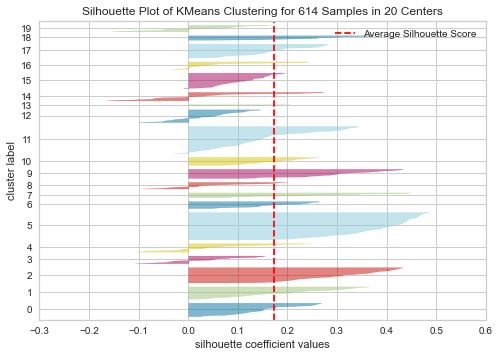

For n_clusters=20, The mean Silhouette Coefficient is 0.17370522799744229
For n_clusters=20, The Davies-Bouldin score is 1.6671037814104186

-----------------------------------
-----------------------------------

21 Clusters


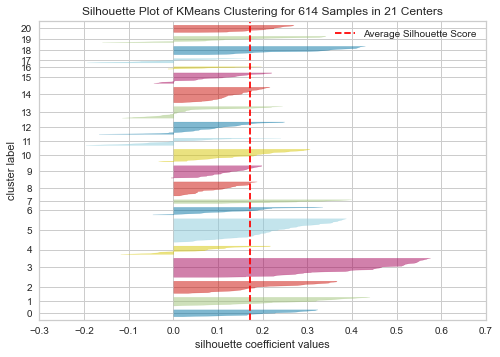

For n_clusters=21, The mean Silhouette Coefficient is 0.17104038937895685
For n_clusters=21, The Davies-Bouldin score is 1.6590518551242124

-----------------------------------
-----------------------------------

22 Clusters


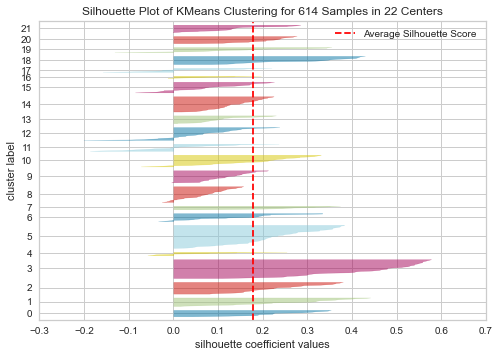

For n_clusters=22, The mean Silhouette Coefficient is 0.17746925424604962
For n_clusters=22, The Davies-Bouldin score is 1.6354779632262668

-----------------------------------
-----------------------------------

23 Clusters


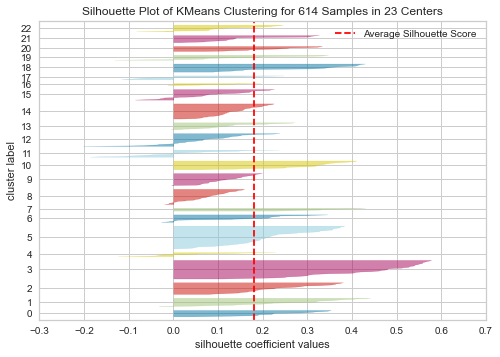

For n_clusters=23, The mean Silhouette Coefficient is 0.18136769216711304
For n_clusters=23, The Davies-Bouldin score is 1.608614421120469

-----------------------------------
-----------------------------------

24 Clusters


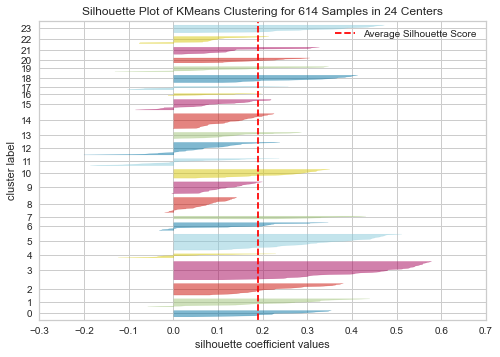

For n_clusters=24, The mean Silhouette Coefficient is 0.1886936291679332
For n_clusters=24, The Davies-Bouldin score is 1.5850024140829275

-----------------------------------
-----------------------------------

25 Clusters


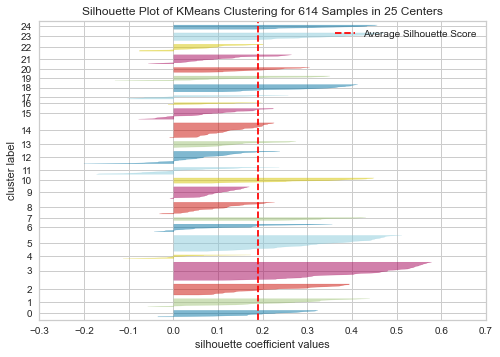

For n_clusters=25, The mean Silhouette Coefficient is 0.18976255087081756
For n_clusters=25, The Davies-Bouldin score is 1.5689608326990165

-----------------------------------
-----------------------------------

26 Clusters


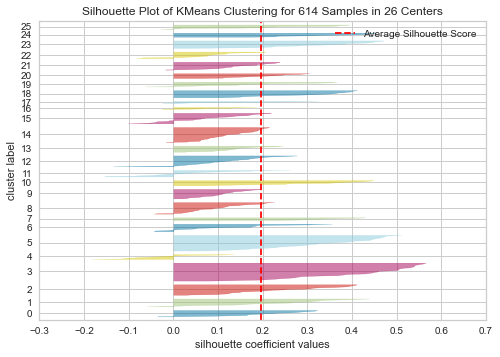

For n_clusters=26, The mean Silhouette Coefficient is 0.19579134228715855
For n_clusters=26, The Davies-Bouldin score is 1.5468028411781383

-----------------------------------
-----------------------------------

27 Clusters


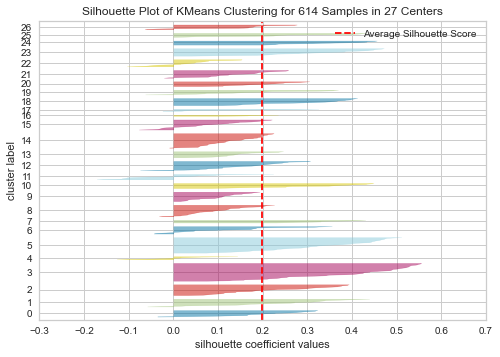

For n_clusters=27, The mean Silhouette Coefficient is 0.19754893981286006
For n_clusters=27, The Davies-Bouldin score is 1.533416411263109

-----------------------------------
-----------------------------------

28 Clusters


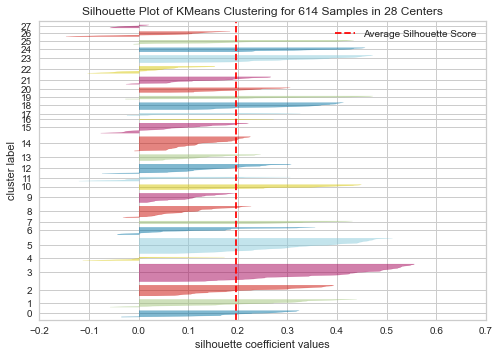

For n_clusters=28, The mean Silhouette Coefficient is 0.1958862132127066
For n_clusters=28, The Davies-Bouldin score is 1.5366348435166817

-----------------------------------
-----------------------------------

29 Clusters


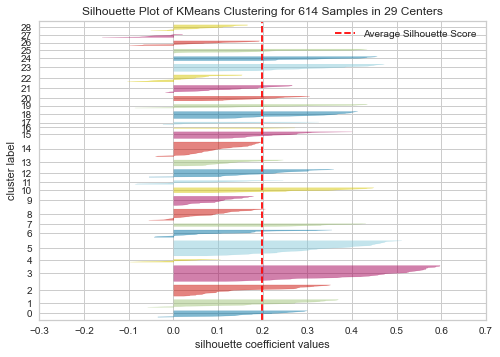

For n_clusters=29, The mean Silhouette Coefficient is 0.1974579291710429
For n_clusters=29, The Davies-Bouldin score is 1.4757676927758752

-----------------------------------
-----------------------------------

30 Clusters


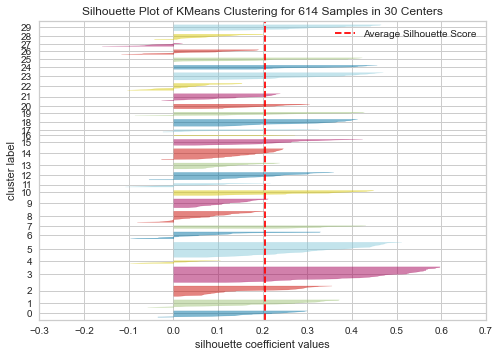

For n_clusters=30, The mean Silhouette Coefficient is 0.20547141097999627
For n_clusters=30, The Davies-Bouldin score is 1.4725403277269613

-----------------------------------


In [208]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer

x_clusters = []
y_sil_coef = []
y_d_b_score = []

for k in k_list:
    kmeans_silhouette = cluster.KMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=300, random_state=1)
    kmeans_silhouette.fit(data)
    label = kmeans_silhouette.labels_
    sil_coeff = silhouette_score(data, label, metric='euclidean')
    x_clusters.append(k)
    y_sil_coef.append(sil_coeff)
     
    print('-----------------------------------\n')
    print(f'{k} Clusters')
    # Plot the sillhoutte coefficients for each cluster 
    visualizer = SilhouetteVisualizer(kmeans_silhouette, colors='yellowbrick')
    visualizer.fit(data)
    visualizer.show()
    print(f'For n_clusters={k}, The mean Silhouette Coefficient is {sil_coeff}')
    
    
    db_score = davies_bouldin_score(data, label)
    y_d_b_score.append(db_score)
    print(f'For n_clusters={k}, The Davies-Bouldin score is {db_score}')
    print('\n-----------------------------------')

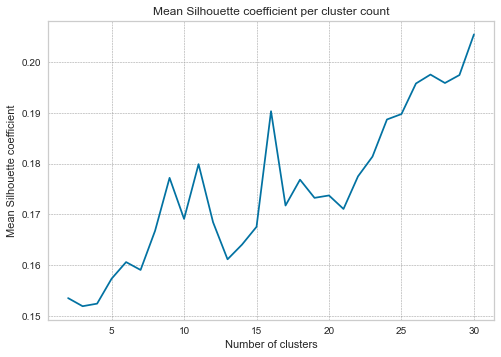

In [209]:
plt.plot(x_clusters, y_sil_coef)
plt.title('Mean Silhouette coefficient per cluster count')
plt.xlabel('Number of clusters')
plt.ylabel('Mean Silhouette coefficient')
plt.grid(color = '#999', linestyle = '--', linewidth = 0.5)
plt.show()

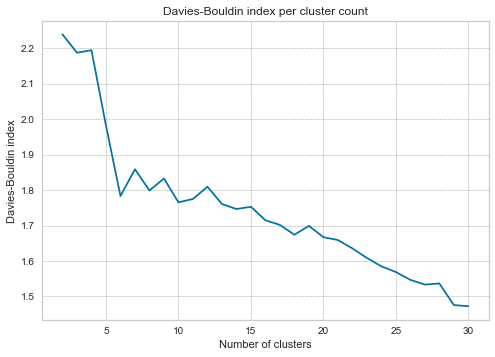

In [210]:
plt.plot(x_clusters, y_d_b_score)
plt.title('Davies-Bouldin index per cluster count')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin index')
plt.grid(color = '#999', linestyle = '--', linewidth = 0.5)
plt.show()

As we can see above, the mean Silhouette coefficent is not much greater than 0 in any case, which indicates that there is likely to be some overlapping in the clusters.

From the silhouette plots, we can clearly see that, from 5 clusters and greater it appears that significant numbers of points are potentially being assigned to clusters incorrectly (where the silhouette coefficient is less than 0). This may present a risk to accuracy in future modelling but it should also be considered in the context of there being no general indication of clear clusters emerging from the data.

The Davies-Bouldin score indicates a modest step-change at k=6, as we have already noted though, there appears to be a significant level of potentially mis-clustered points in this grouping.

### Solving the dilemma
Given that the metrics and evaluation methods above are not really indicating a clearly optimal value of k, I ran through a number of different values of k (3, 4, 5, 6, 11) and carried out a semantic exploration of the clusters for each solution. Based on this, I felt that k=6 provided the better results. Really though, this is based on my own interpretation of the relationships between feature values within the final clusters and it is also possible that patterns I could not discern exist. The ultimate test would be in the performance of any further predicive modelling using the data and the cluster feature. 

For now, we will use **k=6**.

# 3. Plot the clusters
## Use manifold-learning
Apply a manifold-learning technique to project the data into a 2D space

In [211]:
k_optimal = 6
kmeans_optimal = cluster.KMeans(n_clusters=k_optimal, init='k-means++', n_init=1, max_iter=300, random_state=1)

In [212]:
# Fit optimal model
kmeans_optimal.fit(data)

KMeans(n_clusters=6, n_init=1, random_state=1)

In [213]:
data_and_centres = np.r_[data, kmeans_optimal.cluster_centers_]
data_and_centres.shape

(620, 16)

In [214]:
# Project both the data and the k-Means cluster centers to 2D
mani_mds = manifold.MDS(n_components=2, random_state=0, verbose=1)
x_y_coordinates = mani_mds.fit_transform(data_and_centres)
print('transformation complete')

breaking at iteration 278 with stress 69616.17652599674
breaking at iteration 255 with stress 69358.9132312629
transformation complete


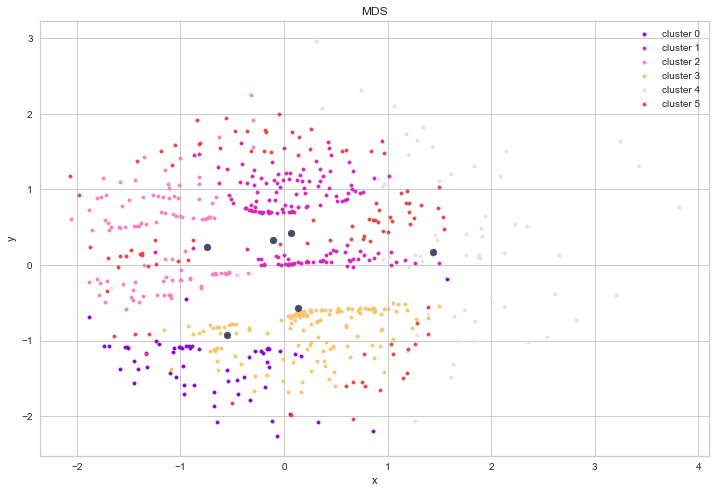

In [215]:
clustering_scatterplot(points=x_y_coordinates[:-k_optimal,:], 
                       labels=kmeans_optimal.labels_, 
                       centers=x_y_coordinates[-k_optimal:,:], 
                       title='MDS')

## Use t-SNE
Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space.

In [216]:
# Project both the data and the k-Means cluster centers to 2D.
mani_tsne = manifold.TSNE(n_components=2, perplexity=30, random_state=0, verbose=1, method='exact')
tsne_x_y_coordinates = mani_tsne.fit_transform(data_and_centres)
print('transformation complete')

[t-SNE] Computing pairwise distances...


/Users/paulhickey/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/paulhickey/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 620 / 620
[t-SNE] Mean sigma: 0.547947
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.184342
[t-SNE] KL divergence after 1000 iterations: 0.548281
transformation complete


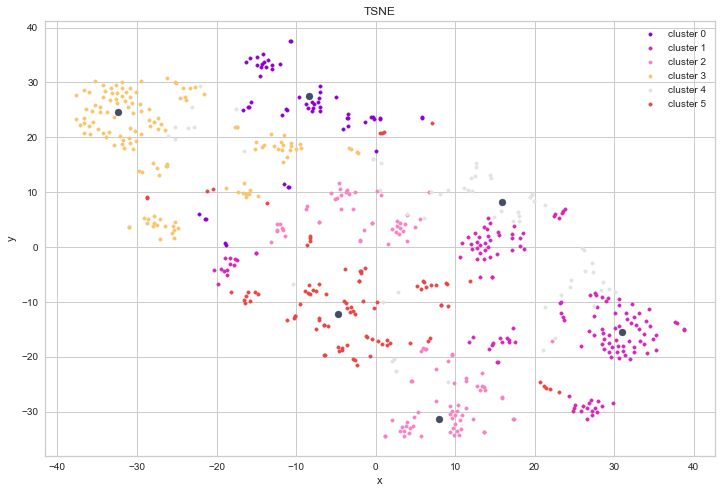

In [217]:
clustering_scatterplot(points=tsne_x_y_coordinates[:-k_optimal,:], 
                       labels=kmeans_optimal.labels_,
                       centers=tsne_x_y_coordinates[-k_optimal:,:], 
                       title='TSNE')

## Use PCA
Reduce dimensionality using Principal Component Analysis

In [218]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_x_y_coordinates = pca.fit_transform(data_and_centres)
print('transformation complete')

transformation complete


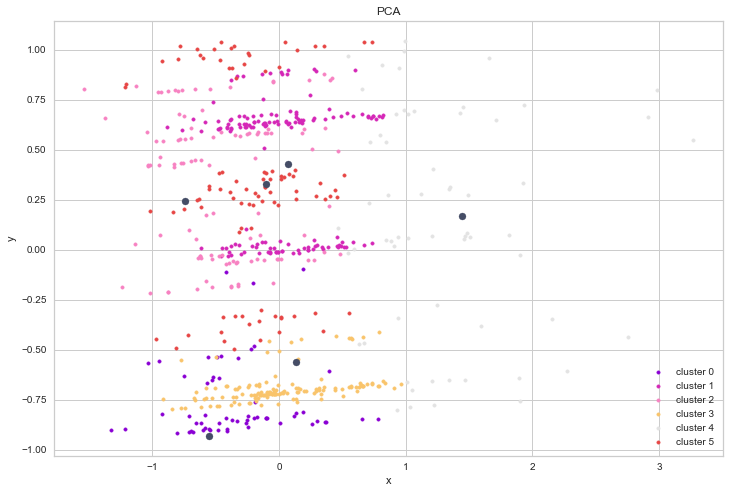

In [219]:
clustering_scatterplot(points=pca_x_y_coordinates[:-k_optimal,:], 
                       labels=kmeans_optimal.labels_, 
                       centers=x_y_coordinates[-k_optimal:,:], 
                       title='PCA')

# 4. Cluster analysis
## Add the clusters as a feature
Append the clusters to the dataframe as an additional feature.

In [220]:
df['cluster'] = pd.Series(kmeans_optimal.labels_, index=df.index)

We would expect to see a fairly balanced distribution of data points amongst the clusters if the grouping is effective.

Text(0.5, 0, 'Data points in cluster')

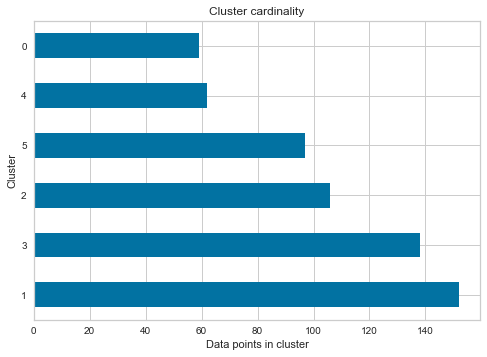

In [221]:
df.cluster.value_counts().plot.barh()
plt.title('Cluster cardinality')
plt.ylabel('Cluster')
plt.xlabel('Data points in cluster')

Based on the plot above, it may be worth investigating clusters 0, 1 and 4 to assess the similarity of points contained with each.

In [222]:
cluster_0 = df.loc[df.cluster == 0]
cluster_1 = df.loc[df.cluster == 1]
cluster_4 = df.loc[df.cluster == 4]

In [223]:
cluster_0.describe()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
count   59.000000        59.000000   59.000000         59.000000   
mean     0.129944         0.816813    0.985404          0.720339   
std      0.239867         0.313318    0.240939          0.132326   
min      0.000000         0.024897    0.353219          0.075000   
25%      0.000000         0.665521    0.882068          0.750000   
50%      0.000000         0.793051    0.979811          0.750000   
75%      0.333333         0.911407    1.097704          0.750000   
max      1.000000         1.849206    1.685034          1.000000   

       Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
count       59.000000         59.0   59.000000    59.000000    59.000000   
mean         0.847458          0.0    0.101695     0.389831     0.016949   
std          0.362632          0.0    0.304841     0.491898     0.130189   
min          0.000000          0.0    0.000000     0.000000     0.000000   
25%          1.000000          0.0    0.000000     0.000000     0.000000   
50%          1.000000          0.0    0.000000     0.000000     0.000000   
75%          1.000000          0.0    0.000000     1.000000     0.000000   
max          1.000000          0.0    1.000000     1.000000     1.000000   

       Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
count          59.000000          59.000000               59.000000   
mean            0.169492           0.084746                0.169492   
std             0.378406           0.280894                0.378406   
min             0.000000           0.000000                0.000000   
25%             0.000000           0.000000                0.000000   
50%             0.000000           0.000000                0.000000   
75%             0.000000           0.000000                0.000000   
max             1.000000           1.000000                1.000000   

       Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
count                59.000000                 59.0      59.000000   
mean                  0.949153                  0.0       0.762712   
std                   0.221572                  0.0       0.429072   
min                   0.000000                  0.0       0.000000   
25%                   1.000000                  0.0       1.000000   
50%                   1.000000                  0.0       1.000000   
75%                   1.000000                  0.0       1.000000   
max                   1.000000                  0.0       1.000000   

       TotalIncome  cluster  
count    59.000000     59.0  
mean      0.710435      0.0  
std       0.297604      0.0  
min       0.149170      0.0  
25%       0.510320      0.0  
50%       0.657982      0.0  
75%       0.885073      0.0  
max       1.662414      0.0

From the detail above, we can see that cluster 0 excludes any observations where *Property_Area_Urban* is true.

In [224]:
cluster_1.describe()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
count  152.000000       152.000000  152.000000        152.000000   
mean     0.335526         0.814499    1.044939          0.694901   
std      0.348436         0.268450    0.269234          0.147561   
min      0.000000         0.259275    0.121394          0.025000   
25%      0.000000         0.608992    0.921362          0.750000   
50%      0.333333         0.763857    1.033622          0.750000   
75%      0.666667         1.024651    1.198493          0.750000   
max      1.000000         1.563106    1.788719          0.750000   

       Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
count      152.000000   152.000000       152.0        152.0        152.0   
mean         0.986842     0.980263         0.0          1.0          0.0   
std          0.114327     0.139554         0.0          0.0          0.0   
min          0.000000     0.000000         0.0          1.0          0.0   
25%          1.000000     1.000000         0.0          1.0          0.0   
50%          1.000000     1.000000         0.0          1.0          0.0   
75%          1.000000     1.000000         0.0          1.0          0.0   
max          1.000000     1.000000         0.0          1.0          0.0   

       Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
count         152.000000         152.000000              152.000000   
mean            0.098684           0.072368                0.203947   
std             0.299223           0.259953                0.404262   
min             0.000000           0.000000                0.000000   
25%             0.000000           0.000000                0.000000   
50%             0.000000           0.000000                0.000000   
75%             0.000000           0.000000                0.000000   
max             1.000000           1.000000                1.000000   

       Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
count                    152.0           152.000000     152.000000   
mean                       0.0             0.625000       0.907895   
std                        0.0             0.485723       0.290130   
min                        0.0             0.000000       0.000000   
25%                        0.0             0.000000       1.000000   
50%                        0.0             1.000000       1.000000   
75%                        0.0             1.000000       1.000000   
max                        0.0             1.000000       1.000000   

       TotalIncome  cluster  
count   152.000000    152.0  
mean      0.798466      1.0  
std       0.238830      0.0  
min       0.252023      1.0  
25%       0.643046      1.0  
50%       0.791761      1.0  
75%       0.952485      1.0  
max       1.392947      1.0

From the detail above, we can see that cluster 1 almost exclusively consists of married males.

In [225]:
df.loc[df.Gender_Male == 1].count()

Dependents                 489
ApplicantIncome            489
LoanAmount                 489
Loan_Amount_Term           489
Credit_History             489
Gender_Male                489
Gender_nan                 489
Married_Yes                489
Married_nan                489
Self_Employed_Yes          489
Self_Employed_nan          489
Education_Not Graduate     489
Property_Area_Semiurban    489
Property_Area_Urban        489
Loan_Status_Y              489
TotalIncome                489
cluster                    489
dtype: int64

As we can see above, most respondents (about 80%) were male, which explains the size of this cluster.

In [226]:
cluster_4.describe()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
count   62.000000        62.000000   62.000000         62.000000   
mean     0.381720         1.768481    1.589602          0.705645   
std      0.385752         0.532844    0.438758          0.126217   
min      0.000000         0.091501    0.668227          0.375000   
25%      0.000000         1.477237    1.280352          0.750000   
50%      0.333333         1.756060    1.588523          0.750000   
75%      0.666667         1.963157    1.908270          0.750000   
max      1.000000         3.357480    2.461145          1.000000   

       Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
count       62.000000    62.000000   62.000000    62.000000         62.0   
mean         0.854839     0.806452    0.064516     0.725806          0.0   
std          0.355139     0.398304    0.247676     0.449749          0.0   
min          0.000000     0.000000    0.000000     0.000000          0.0   
25%          1.000000     1.000000    0.000000     0.000000          0.0   
50%          1.000000     1.000000    0.000000     1.000000          0.0   
75%          1.000000     1.000000    0.000000     1.000000          0.0   
max          1.000000     1.000000    1.000000     1.000000          0.0   

       Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
count          62.000000          62.000000               62.000000   
mean            0.338710           0.048387                0.032258   
std             0.477134           0.216335                0.178127   
min             0.000000           0.000000                0.000000   
25%             0.000000           0.000000                0.000000   
50%             0.000000           0.000000                0.000000   
75%             1.000000           0.000000                0.000000   
max             1.000000           1.000000                1.000000   

       Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
count                62.000000            62.000000      62.000000   
mean                  0.290323             0.322581       0.629032   
std                   0.457617             0.471280       0.487007   
min                   0.000000             0.000000       0.000000   
25%                   0.000000             0.000000       0.000000   
50%                   0.000000             0.000000       1.000000   
75%                   1.000000             1.000000       1.000000   
max                   1.000000             1.000000       1.000000   

       TotalIncome  cluster  
count    62.000000     62.0  
mean      1.752486      4.0  
std       0.433119      0.0  
min       1.196233      4.0  
25%       1.437569      4.0  
50%       1.652405      4.0  
75%       1.877002      4.0  
max       3.207353      4.0

Based on the details above, it appears that cluster 4 is handling the very highest earners who also attracted high loan amounts. The cluster is small because this is in itself a group consisting largely of outliers.

## Compute the mean value of each attribute by cluster

In [227]:
grouped = df.groupby('cluster')
grouped.mean()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
cluster                                                              
0          0.129944         0.816813    0.985404          0.720339   
1          0.335526         0.814499    1.044939          0.694901   
2          0.056604         0.817489    0.936000          0.739387   
3          0.263285         0.842949    1.064257          0.723732   
4          0.381720         1.768481    1.589602          0.705645   
5          0.285223         0.805803    1.022599          0.699742   

         Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
cluster                                                                      
0              0.847458     0.000000    0.101695     0.389831     0.016949   
1              0.986842     0.980263    0.000000     1.000000     0.000000   
2              0.952830     0.603774    0.009434     0.000000     0.009434   
3              0.985507     1.000000    0.000000     0.746377     0.007246   
4              0.854839     0.806452    0.064516     0.725806     0.000000   
5              0.360825     0.907216    0.020619     0.773196     0.000000   

         Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
cluster                                                                 
0                 0.169492           0.084746                0.169492   
1                 0.098684           0.072368                0.203947   
2                 0.094340           0.066038                0.160377   
3                 0.115942           0.021739                0.195652   
4                 0.338710           0.048387                0.032258   
5                 0.103093           0.030928                0.484536   

         Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
cluster                                                                
0                       0.949153             0.000000       0.762712   
1                       0.000000             0.625000       0.907895   
2                       0.000000             0.566038       0.707547   
3                       1.000000             0.000000       0.905797   
4                       0.290323             0.322581       0.629032   
5                       0.216495             0.278351       0.000000   

         TotalIncome  
cluster               
0           0.710435  
1           0.798466  
2           0.704128  
3           0.810867  
4           1.752486  
5           0.734177

## Observations on cluster characteristics

- Cluster 0 appears to be reserved for non-males, with semi urban properties.
- Cluster 1 seems to represent married people (for the most part men) with urban properties.
- Cluster 2 may represent people who are unmarried, have few or no dependents and have an urban property.
- Cluster 3 is for individuals who are exclusively male and have a semi urban property.
- Cluster 4, as mentioned already, appears be heavily influenced by ApplicantIncome, TotalIncome and also LoanAmount.
- Cluster 5 seems to represent individuals with a lower value for Credit_History and who tend not to be graduates.

As a final data preparation step, it would be best to categorically encode the clusters before carrying out predictive modelling.

# 5. Additional clustering methods
## Agglomerative clustering
Agglomerative clustering is a "bottom-up" hierarchical approach. It begins by treating each individual data point as a single cluster. It then merges points continuously based on similarity until a single cluster containing all data points is formed.

A benefit of this approach is that it provides a good insight into the merging process. A challenge is that we are left to select the optimal clustering.

In [228]:
from sklearn.cluster import AgglomerativeClustering

ag_cluster = AgglomerativeClustering(n_clusters=k_optimal, compute_distances=True).fit(data)
ag_cluster

AgglomerativeClustering(compute_distances=True, n_clusters=6)

In [229]:
ag_labels = ag_cluster.labels_

/var/folders/zr/nm1s0nc11ys9zwdw994bj8pw0000gn/T/ipykernel_87293/1065092849.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


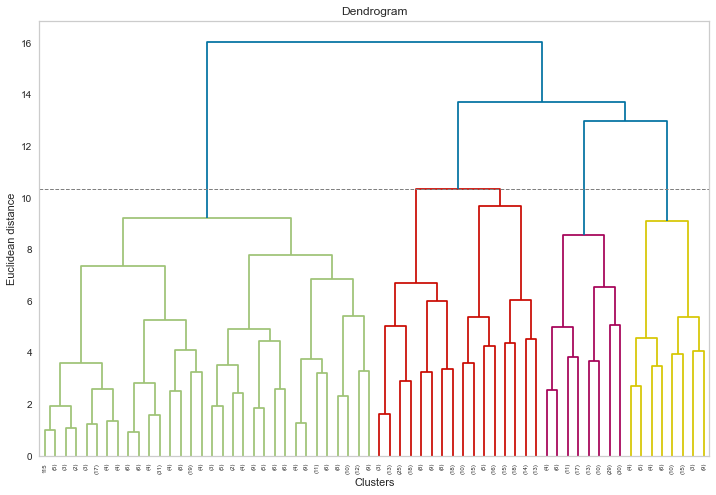

In [230]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(12,8))
dendrogram = sch.dendrogram(sch.linkage(data, method='ward'), truncate_mode='level', p=5)
plt.axhline(y=10.35, c='grey', lw=1, linestyle='dashed')
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distance')
plt.grid(b=None)

In choosing an optimal threshold from a dendrogram (as shown above), a rule of thumb is to look for the longest vertical line (here representing the greatest Euclidean distance) that does not cross any of the *cap-lines* extended horizontally. In the case above, this would give us **5 clusters**.

## Clustering with DBSCAN
DBSCAN, or density-based spatial clustering of applications with noise, operates by categorising *densely grouped* data points as a single cluster. It can identify clusters in large spatial datasets by looking at the local density of the data points. 

Additional benefits are is that it is robust to outliers and noise and it does not require the number of clusters to be specified in advance.

In [231]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(data)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
db_sil_coef = silhouette_score(data, labels, metric='euclidean')

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')
print(f'Mean Silhouette coefficient is {db_sil_coef}')

db_davboul_score = davies_bouldin_score(data, labels)
print(f'Davies-Bouldin score is {db_davboul_score}')

Estimated number of clusters: 3
Estimated number of noise points: 566
Mean Silhouette coefficient is -0.22225454996917182
Davies-Bouldin score is 1.6933051700416157


## Observations on other clustering approaches

### Agglomerative
As with k-means, it is unclear from the Agglomerative clustering what is the optimal number of clusters that we should choose. The visualisation has been truncated at the 5th level of branching and, based on a visual assessment, a case could perhaps be made for choosing 3, 4, 5 or 6 clusters. The rules of thumb we have opted for suggests 5 clusters.

Key differences between agglomerative clustering and k-means are
- k-means requires that number of clusters is set in advance
- they essentially work in opposite directions, with k-means beginning with centroids that dictate the clusters that will be formed, whilst agglomerative creates connections between individual points, building clusters from there.

### DBSCAN
The results of DBSCAN are surprising in the extent to which they differ from the results of the k-means approach. The mean silhouette coefficient indicates quite a bit of uncertainty in the quality of the clusters, with the low value indicating a likelihood that the groupings are inaccurate.

We can also see that we get an even higher Davies-Bouldin score here than previously that indicates an even lower average similarity measure between each cluster and its most similar cluster.

All in all, the general conclusion we might draw from this exercise is that this dataset may not be a great candidate for clustering.